In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, Flatten
from keras.optimizers import Adam
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.losses import binary_crossentropy

#### Preprocessing

In [2]:
data = pd.read_csv('fake_job_postings.csv')
text = data['description'].astype(str)
labels = data['fraudulent']
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(text)
sequences = tokenizer.texts_to_sequences(text)
word_index = tokenizer.word_index
max_length = max([len(s) for s in sequences])
data = pad_sequences(sequences, maxlen=max_length)
data.shape, max_length

((17880, 2031), 2031)

Look at data

In [3]:
data[:5]

array([[   0,    0,    0, ...,    1,  431,  175],
       [   0,    0,    0, ...,    2,  817,   23],
       [   0,    0,    0, ...,    1,  282, 1335],
       [   0,    0,    0, ...,    3,  824,  217],
       [   0,    0,    0, ...,  128,  981,    8]])

Train test split

In [4]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42, stratify=labels)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
print(f"X_train.shape: {X_train.shape}, y_train.shape: {y_train.shape} --> {X_train.shape[0]/(X_train.shape[0]+X_val.shape[0]+X_test.shape[0]) * 100:.2f}%")
print(f"X_val.shape: {X_val.shape}, y_val.shape: {y_val.shape} --> {X_val.shape[0]/(X_train.shape[0]+X_val.shape[0]+X_test.shape[0]) * 100:.2f}%")
print(f"X_test.shape: {X_test.shape}, y_test.shape: {y_test.shape} --> {X_test.shape[0]/(X_train.shape[0]+X_val.shape[0]+X_test.shape[0]) * 100:.2f}%")

X_train.shape: (11443, 2031), y_train.shape: (11443,) --> 64.00%
X_val.shape: (2861, 2031), y_val.shape: (2861,) --> 16.00%
X_test.shape: (3576, 2031), y_test.shape: (3576,) --> 20.00%


Build Model
1. Embedding-Schicht: <br>
    Die erste Schicht des Modells ist eine Embedding-Schicht, die dazu dient, eine Darstellung der Wörter im Text zu lernen. In dieser Schicht wird jeder Token (d.h. jedes Wort im Text) in eine Vektordarstellung umgewandelt. Die Größe der Vektoren wird durch den Parameter "output_dim" (in diesem Fall 100) festgelegt, während der Parameter "input_length" die Länge des Eingabesequenz definiert. Durch die Verwendung von Embedding-Schichten kann das Modell semantische Beziehungen zwischen Wörtern lernen und die Textklassifikation verbessern.
2. Flatten: <br>
    Bring 100 dimensional Tensor to a 1 dimensional

In [5]:
model = Sequential()
model.add(Embedding(5000, 100, input_length=max_length))
model.add(Flatten())
model.add(Dense(64,
                kernel_initializer='random_normal', # weights
                bias_initializer='zeros',           # bias
                bias_regularizer='l1',              # Regularization
                activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss=binary_crossentropy, 
              optimizer=Adam(learning_rate=0.001), 
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 2031, 100)         500000    
                                                                 
 flatten (Flatten)           (None, 203100)            0         
                                                                 
 dense (Dense)               (None, 64)                12998464  
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 13,498,529
Trainable params: 13,498,529
Non-trainable params: 0
_________________________________________________________________


Fit Model

In [6]:
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_val, y_val))

Epoch 1/10
179/179 [==============================] - 13s 70ms/step - loss: 0.2556 - accuracy: 0.9465 - val_loss: 0.1460 - val_accuracy: 0.9556
Epoch 2/10
179/179 [==============================] - 12s 68ms/step - loss: 0.1236 - accuracy: 0.9544 - val_loss: 0.1120 - val_accuracy: 0.9706
Epoch 3/10
179/179 [==============================] - 12s 69ms/step - loss: 0.0600 - accuracy: 0.9739 - val_loss: 0.1156 - val_accuracy: 0.9731
Epoch 4/10
179/179 [==============================] - 12s 68ms/step - loss: 0.0274 - accuracy: 0.9906 - val_loss: 0.1326 - val_accuracy: 0.9755
Epoch 5/10
179/179 [==============================] - 12s 68ms/step - loss: 0.0096 - accuracy: 0.9985 - val_loss: 0.1892 - val_accuracy: 0.9752
Epoch 6/10
179/179 [==============================] - 12s 67ms/step - loss: 0.0092 - accuracy: 0.9983 - val_loss: 0.1712 - val_accuracy: 0.9748
Epoch 7/10
179/179 [==============================] - 12s 67ms/step - loss: 0.0059 - accuracy: 0.9984 - val_loss: 0.2029 - val_accuracy:

Evaluate model

In [7]:
# 1: Test Loss: 0.157, Test Accuracy: 0.978
# mit Adam(learning_rate=0.001)
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print(f'1: Test Loss: {loss:.3}, Test Accuracy: {accuracy:.3}')

1: Test Loss: 0.178, Test Accuracy: 0.978


Confusion Matrix

In [8]:
y_pred = model.predict(X_test)
y_pred = np.round(y_pred)
# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred)

112/112 [==============================] - 1s 11ms/step


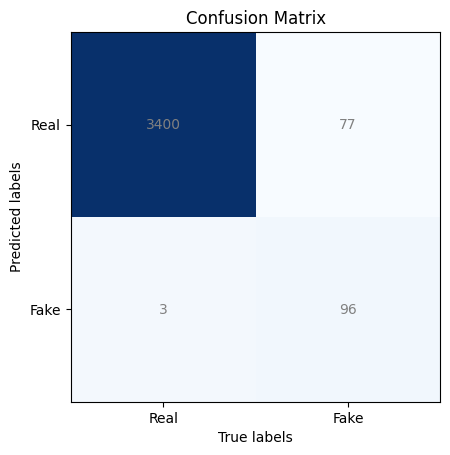

In [9]:

# Plot the confusion matrix
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.xlabel("True labels")
plt.ylabel("Predicted labels")
plt.xticks([0, 1], ['Real', 'Fake'])
plt.yticks([0, 1], ['Real', 'Fake'])
plt.text(0, 0, cm[0,0], ha="center", va="center", color="grey")
plt.text(0, 1, cm[0,1], ha="center", va="center", color="grey")
plt.text(1, 0, cm[1,0], ha="center", va="center", color="grey")
plt.text(1, 1, cm[1,1], ha="center", va="center", color="grey")
plt.show()